<a href="https://colab.research.google.com/github/quangnhat1395/MLEF1/blob/master/UEL_MLEF1_credit_scoring_decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Download credit dataset
dataset_url = 'https://www.engineeringbigdata.com/wp-content/uploads/credit.csv'
df = pd.read_csv(dataset_url)

In [ ]:
df.head()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
0,< 0 DM,6,critical,furniture/appliances,1169,unknown,> 7 years,4,4,67,none,own,2,skilled,1,yes,no
1,1 - 200 DM,48,good,furniture/appliances,5951,< 100 DM,1 - 4 years,2,2,22,none,own,1,skilled,1,no,yes
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 years,2,3,49,none,own,1,unskilled,2,no,no
3,< 0 DM,42,good,furniture/appliances,7882,< 100 DM,4 - 7 years,2,4,45,none,other,1,skilled,2,no,no
4,< 0 DM,24,poor,car,4870,< 100 DM,1 - 4 years,3,4,53,none,other,2,skilled,2,no,yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   checking_balance      1000 non-null   object
 1   months_loan_duration  1000 non-null   int64 
 2   credit_history        1000 non-null   object
 3   purpose               1000 non-null   object
 4   amount                1000 non-null   int64 
 5   savings_balance       1000 non-null   object
 6   employment_duration   1000 non-null   object
 7   percent_of_income     1000 non-null   int64 
 8   years_at_residence    1000 non-null   int64 
 9   age                   1000 non-null   int64 
 10  other_credit          1000 non-null   object
 11  housing               1000 non-null   object
 12  existing_loans_count  1000 non-null   int64 
 13  job                   1000 non-null   object
 14  dependents            1000 non-null   int64 
 15  phone                 1000 non-null   o

## Visualization

### Overall data distribution

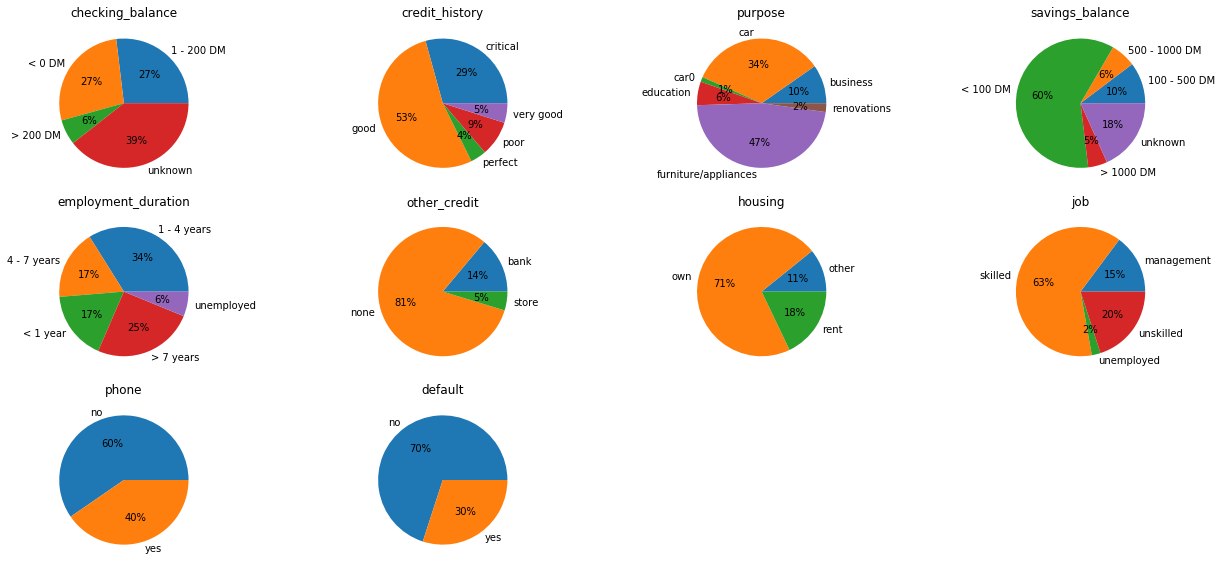

In [ ]:
# Investigate columns with categorical type
categorical_columns = df.select_dtypes('object').columns
nr = -(-len(categorical_columns) // 4)
fig, axes = plt.subplots(ncols=4, 
                         nrows=nr,
                         figsize=(len(categorical_columns) * 1.8, 8))

for col, ax in zip(categorical_columns, axes.ravel()):
  df.groupby(col)\
    .size()\
    .plot\
    .pie(y=col,
         ax=ax, 
         autopct='%1.0f%%')
  ax.set_title(col)
  ax.set_ylabel('')

for ax in axes.ravel()[len(categorical_columns):]:
  ax.remove()

fig.tight_layout()
plt.show()

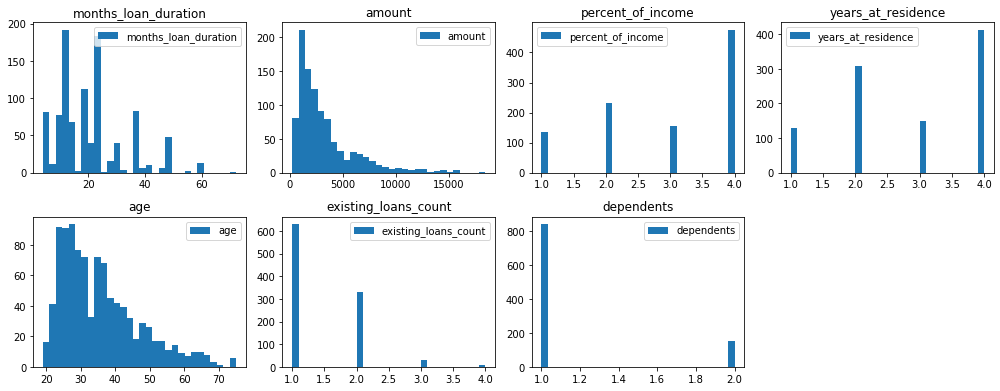

In [ ]:
# Investigate numerical columns
numerical_columns = df.select_dtypes('int64').columns
nr = -(-len(categorical_columns) // 4)
fig, axes = plt.subplots(ncols=4, 
                         nrows=nr,
                         figsize=(len(numerical_columns) * 2, 8))

for col, ax in zip(numerical_columns, axes.ravel()):
  df.plot\
    .hist(y=col,
          ax=ax,
          bins=30)
  ax.set_title(col)
  ax.set_ylabel('')

for ax in axes.ravel()[len(numerical_columns):]:
  ax.remove()

fig.tight_layout()
plt.show()

### Attribution of each feature to the label

### Numerical variables

In [ ]:
# Let's see how each attributes correlates with the label
# Let's convert the label to numerical form first
df['default_as_num'] = df['default'].apply(lambda x: 1 if x == 'yes' else 0)

In [ ]:
# corr() function only takes into acount numerical attributes
correlation_matrix = df.corr()
correlation_matrix

,months_loan_duration,amount,percent_of_income,years_at_residence,age,existing_loans_count,dependents,default_as_num
months_loan_duration,1.000000,0.624984,0.074749,0.034067,-0.036136,-0.011284,-0.023834,0.214927
amount,0.624984,1.000000,-0.271316,0.028926,0.032716,0.020795,0.017142,0.154739
percent_of_income,0.074749,-0.271316,1.000000,0.049302,0.058266,0.021669,-0.071207,0.072404
years_at_residence,0.034067,0.028926,0.049302,1.000000,0.266419,0.089625,0.042643,0.002967
age,-0.036136,0.032716,0.058266,0.266419,1.000000,0.149254,0.118201,-0.091127
existing_loans_count,-0.011284,0.020795,0.021669,0.089625,0.149254,1.000000,0.109667,-0.045732
dependents,-0.023834,0.017142,-0.071207,0.042643,0.118201,0.109667,1.000000,-0.003015
default_as_num,0.214927,0.154739,0.072404,0.002967,-0.091127,-0.045732,-0.003015,1.000000


In [ ]:
# Visualize it on a grid map
# As we can see here, the label has high correlation with 2 variables: months_loan_duration and amount
# and yet they are highly correlated themselves (0.62).
correlation_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)

,months_loan_duration,amount,percent_of_income,years_at_residence,age,existing_loans_count,dependents,default_as_num
months_loan_duration,1,0.62,0.075,0.034,-0.036,-0.011,-0.024,0.21
amount,0.62,1,-0.27,0.029,0.033,0.021,0.017,0.15
percent_of_income,0.075,-0.27,1,0.049,0.058,0.022,-0.071,0.072
years_at_residence,0.034,0.029,0.049,1,0.27,0.09,0.043,0.003
age,-0.036,0.033,0.058,0.27,1,0.15,0.12,-0.091
existing_loans_count,-0.011,0.021,0.022,0.09,0.15,1,0.11,-0.046
dependents,-0.024,0.017,-0.071,0.043,0.12,0.11,1,-0.003
default_as_num,0.21,0.15,0.072,0.003,-0.091,-0.046,-0.003,1


### Categorical variables

In [ ]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2

def chi_squared_test(table, critical_or_pvalue='pvalue'):
  stat, p, dof, expected = chi2_contingency(table)
  # print('dof=%d' % dof)
  # print(expected)
  # interpret test-statistic
  prob = 0.95
  alpha = 1.0 - prob
  if critical_or_pvalue == 'critical' or critical_or_pvalue == 'both':
    critical = chi2.ppf(prob, dof)
    print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
    if abs(stat) >= critical:
      print('Dependent (reject H0)')
    else:
      print('Independent (fail to reject H0)')
  elif critical_or_pvalue == 'pvalue' or critical_or_pvalue == 'both':
    # interpret p-value
    print('significance=%.3f, p=%.3f' % (alpha, p))
    if p <= alpha:
      print('Dependent (reject H0)')
    else:
      print('Independent (fail to reject H0)')

In [ ]:
# For categorical attributes, we create a contingency table 
# for each attribute and the label then perform the chi-squared test 
# to test if each of them are assosiated with the label
# => It turns out that purpose/job/phone don't affected the credit
for col in categorical_columns[:-1]:
  _crtable = pd.DataFrame(pd.crosstab(df[col], df['default']).to_dict()).reset_index()
  print('===============================================')
  print(col)
  chi_squared_test(_crtable.drop(_crtable.columns[0], axis=1).values)
  _crtable['pct_good'] = _crtable['yes'] / (_crtable['yes'] + _crtable['no'])
  print(_crtable)
  print('===============================================')

checking_balance
significance=0.050, p=0.000
Dependent (reject H0)
        index   no  yes  pct_good
0  1 - 200 DM  164  105  0.390335
1      < 0 DM  139  135  0.492701
2    > 200 DM   49   14  0.222222
3     unknown  348   46  0.116751
credit_history
significance=0.050, p=0.000
Dependent (reject H0)
       index   no  yes  pct_good
0   critical  243   50  0.170648
1       good  361  169  0.318868
2    perfect   15   25  0.625000
3       poor   60   28  0.318182
4  very good   21   28  0.571429
purpose
significance=0.050, p=0.145
Independent (fail to reject H0)
                  index   no  yes  pct_good
0              business   63   34  0.350515
1                   car  231  106  0.314540
2                  car0    7    5  0.416667
3             education   36   23  0.389831
4  furniture/appliances  349  124  0.262156
5           renovations   14    8  0.363636
savings_balance
significance=0.050, p=0.000
Dependent (reject H0)
           index   no  yes  pct_good
0   100 - 500 DM   69

## Prepare data for training

In [ ]:
from sklearn.model_selection import train_test_split
# We split the original data into 2 parts: training, test
X, y = df.drop(['default', 'default_as_num'], axis=1), df['default_as_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=36)

## Variables encoding

Although decision tree algirithm, hypothetically can handle categorical variable, we still need to convert them in the dataframe into numerical form.

In [ ]:
def one_hot_encoder(df, nan_as_category = False):
  original_columns = list(df.columns)
  categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
  return pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category, drop_first=True)

def fill_missing_columns(data_train, data_test):
  missing_cols = set(data_train.columns) - set(data_test.columns)
  for c in missing_cols:
    data_test[c] = 0

In [ ]:
X_train = one_hot_encoder(X_train)
X_test = one_hot_encoder(X_test)

# Fill missing columns in case of data test is smaller, we must do this instead
# of concatinating train and test dataset to create dummy variables since we can
# not see the future
fill_missing_columns(X_train, X_test)

# You need to have the same order of columns for model training/prediction
X_test = X_test[X_train.columns]

## Training and hyper-parameters tunning

In [ ]:
import math
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve

In [ ]:
def tunning_procedure(X_train, y_train, 
                      X_test, y_test):
  decision_tree_model = DecisionTreeClassifier(random_state=36)
  param_grid = {
      'criterion': ['gini', 'entropy'],
      'max_depth': range(2, 5),
      'min_samples_split': range(2, 5),
      'min_samples_leaf': range(2, 5)
  }
  grid = GridSearchCV(decision_tree_model, 
                      param_grid, 
                      cv=5, 
                      scoring='roc_auc', 
                      verbose=True, 
                      n_jobs=-1)
  best_tree = grid.fit(X_train, y_train)
  y_train_pred = best_tree.predict(X_train)
  y_test_pred = best_tree.predict(X_test) 
  return best_tree

In [ ]:
best_tree = tunning_procedure(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    3.2s finished


In [ ]:
best_tree.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [ ]:
# Get model's probability prediction (number of positive example divided by 
# total number of examples in leaf node )
y_train_pred_proba = best_tree.predict_proba(X_train)[:, 1]
y_test_pred_proba = best_tree.predict_proba(X_test)[:, 1]
# Get model's hard prediction (label:0/1 based on probability threshold of 0.5)
y_train_pred = best_tree.predict(X_train)
y_test_pred = best_tree.predict(X_test)

In [ ]:
print('AUC score on training data: {:.2f}'.format(roc_auc_score(y_train, y_train_pred_proba)))
print('AUC score on test data: {:.2f}'.format(roc_auc_score(y_test, y_test_pred_proba)))

AUC score on training data: 0.80
AUC score on test data: 0.73


In [ ]:
print('ON TRAINING SET')
print(classification_report(y_train, y_train_pred))
print('ON TEST SET')
print(classification_report(y_test, y_test_pred))

ON TRAINING SET
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       487
           1       0.77      0.35      0.48       213

    accuracy                           0.77       700
   macro avg       0.77      0.65      0.67       700
weighted avg       0.77      0.77      0.74       700

ON TEST SET
              precision    recall  f1-score   support

           0       0.76      0.94      0.84       213
           1       0.65      0.28      0.39        87

    accuracy                           0.75       300
   macro avg       0.70      0.61      0.61       300
weighted avg       0.73      0.75      0.71       300



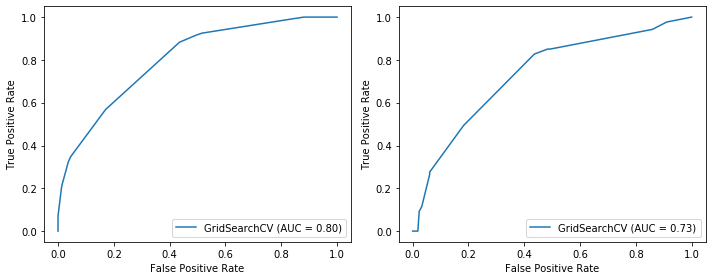

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
plot_roc_curve(best_tree, X_train, y_train, ax=axes[0])
plot_roc_curve(best_tree, X_test, y_test, ax=axes[1])

fig.tight_layout()
plt.show()

## Decision thresholds visualization


In [ ]:
from sklearn import tree
import graphviz

In [ ]:
dot_data = tree.export_graphviz(best_tree.best_estimator_, 
                                feature_names=list(X_train.columns))
graph = graphviz.Source(dot_data)
graph.render('decision_tree') # export decision thresholds to the pdf file named 'decision_tree'

'decision_tree.pdf'

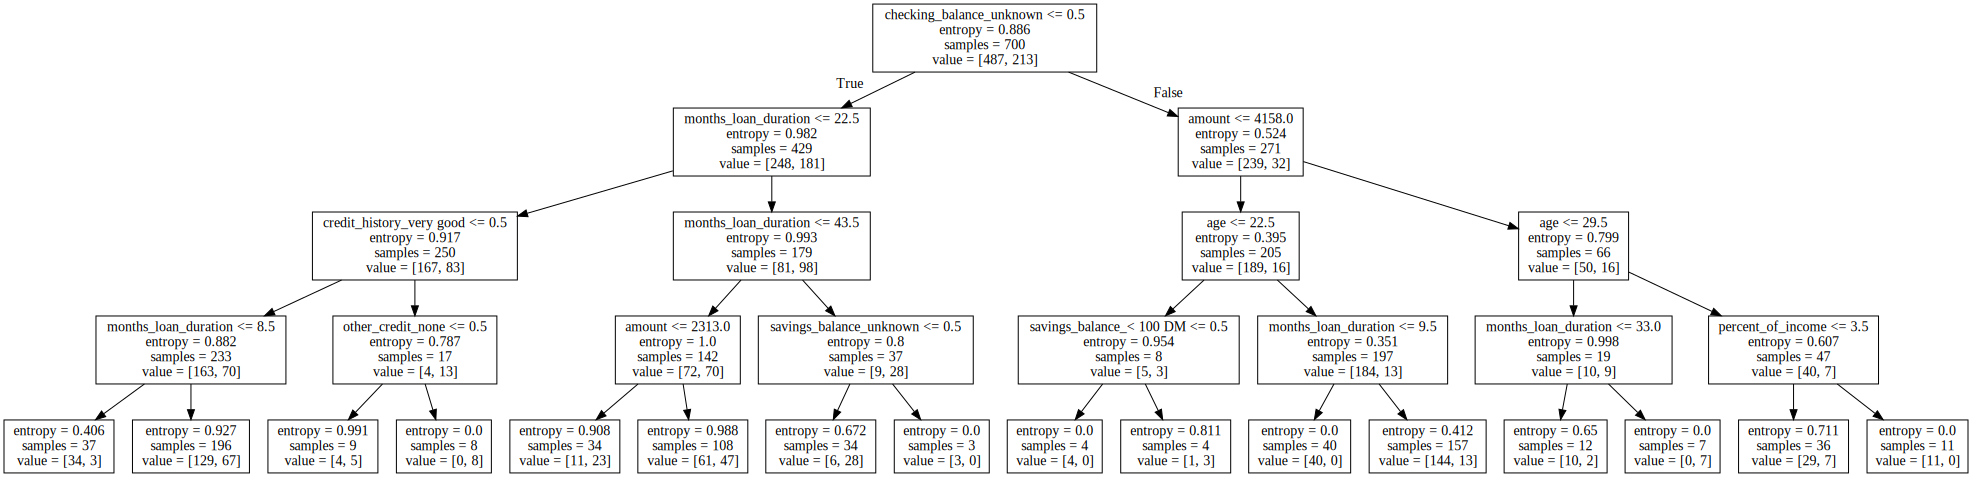

In [ ]:
graph